In [ ]:
#The Name Of The EXPERMENT // skip it if you just test the model
EXPERMENT_NAME = 'HeartClassificationTemplateFreeStyle2_GELU'

## Load Dataset

In [ ]:
# connect to google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy data mitbih dataset from google drive to colab
!cp /content/drive/MyDrive/FcaiBsuTeam/Software/Training/DataSet/mitbih.csv.zip /content/

In [ ]:
!cp /content/drive/MyDrive/FcaiBsuTeam/Software/Training/DataSet/mitbih_test.csv /content/

In [ ]:
# if you faced any problem in copy this data to your work enviroment here just uncomment these 2 line and run this cell
#!gdown 1HpF9h3ZQ7z9S7WK0APvZr9jf-J5ZfZD8
#!gdwon 1HbHfJYJq7YGXJdm-PeXRfcM830aY7Ass

### install dependencies

In [ ]:
%%bash
pip install pytorch-lightning
pip install wandb
pip install optuna

### Import Libs

In [ ]:
import wandb
import pandas as pd
from pytorch_lightning.loggers import WandbLogger
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from sklearn.model_selection import train_test_split

In [ ]:
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from torch.utils.data import Dataset , DataLoader
from sklearn.utils import shuffle

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

### wandb settings

In [ ]:
# you need to use this accsess key below : 31880a10cc6e931ba2603689e6afb0ae48f3d0c1

In [ ]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb_logger = WandbLogger(project = "HeartClassification" , entity = "muhammed266")

wandb: Currently logged in as: muhammed266. Use `wandb login --relogin` to force relogin


### Define DataLoader

In [ ]:
# here we define ECGDATASET DataSet Sampler
# that take csv file and return when calling __getitem__ datapoint ready to use in our model
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        # we need to convert dtype of the data to float and the target to long
        # and all od them to torch Tensors
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
      return len(self.df)

In [ ]:
# Here we

# 2 We also add some settings and values ​​such as batch size , test size

class dataloader(pl.LightningDataModule):
    def __init__(self , train_path , batch_size ):
        super().__init__()

        self.batch_size = batch_size
        self.train_path = train_path

    def prepare(self):
      # Devide ourdataset to train / validation
      # define (train data sampler , validation data) sampler
      df = pd.read_csv(self.train_path)
      train_df, val_df = train_test_split(df, test_size=0.15 , random_state=2021 ,  stratify=df['label'])

      self.train_df, self.val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

      self.train_dataset = ECGDataset(self.train_df)
      self.valid_dataset = ECGDataset(self.val_df)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset , batch_size = self.batch_size )

In [ ]:
data = dataloader("/content/mitbih.csv.zip" , 200)
data.prepare()

## Define The Model And Metaheuristic Optimization

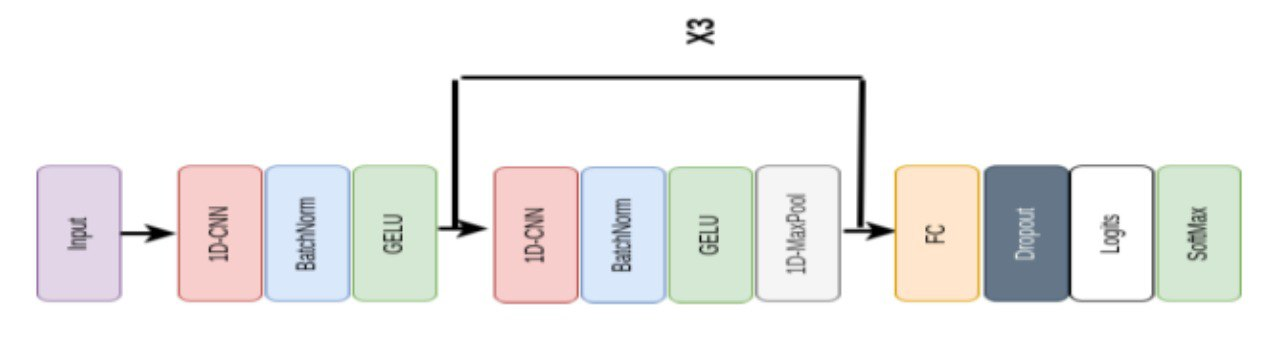

In [ ]:
!pip install pyMetaheuristic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 3.5 MB/s 


In [ ]:
from pyMetaheuristic.algorithm  import arithmetic_optimization_algorithm
from pyMetaheuristic.utils import graphs

In [ ]:
# define model with variable parameters

class  Model(pl.LightningModule):

    def __init__(self, num_of_class, lr, num_layer, dropout):
        super(Model, self).__init__()
        self.lr = lr
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1 , padding = 1),
            nn.BatchNorm1d(32) ,
            nn.ReLU() ,

            nn.Conv1d(32 , 64 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(64) ,
            nn.ReLU() ,
            nn.MaxPool1d(3),

            nn.Conv1d(64 , 128 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(128) ,
            nn.ReLU() ,
            nn.MaxPool1d(3) ,

            nn.Conv1d(128 , 256 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(256) ,
            nn.ReLU() ,
            nn.Dropout(dropout))

        self.linear = nn.Sequential(
            nn.Linear(5120,int(num_layer)) ,
            nn.Dropout(dropout) ,
            nn.LeakyReLU(inplace = True) ,
            nn.Linear(int(num_layer) , num_of_class)
        )

    def forward(self,x):
        # x = x.unsqueeze(1)
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = self.lr)

    def training_step(self , batch , batch_idx):
        src , trg = batch
        preds = self(src)
        loss  = F.cross_entropy(preds , trg)
        acc   = (preds.argmax(dim = -1) == trg).float().mean()

        self.log("train_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
        self.log("train_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)

        return loss

    def validation_step(self , batch , batch_idx):
        src , trg = batch
        preds = self(src)
        loss  = F.cross_entropy(preds , trg)
        acc   = (preds.argmax(dim = -1) == trg).float().mean()

        self.log("val_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
        self.log("val_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)

    def test_step(self , batch , batch_idx):
      src , trg = batch
      preds = self(src)
      loss  = F.cross_entropy(preds , trg)
      acc   = (preds.argmax(dim = -1) == trg).float().mean()
      self.log("test_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
      self.log("test_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)
      return {"loss" : loss ,
              "accuracy" : acc}

In [ ]:
data = dataloader("/content/mitbih.csv.zip" , 96)
data.prepare()

In [ ]:
# Target Function - It can be any function that needs to be minimize

num_classes = 5
def targetFunction(variables_values = [0, 0, 0]):
    lr, num_layer, dropout = variables_values
    model = Model(num_classes, lr, num_layer, dropout)
    trainer_CNN = pl.Trainer(log_every_n_steps = 1 , deterministic = True , gpus = 1 , max_epochs = 5 , fast_dev_run = False , logger = wandb_logger)
    trainer_CNN.fit(model, data)
    loss = trainer_CNN.logged_metrics['val_loss_epoch'].item()

    return loss

In [ ]:
# AOA - Parameters
parameters = {
    'size': 10,
    'min_values': (0.00001, 32, 0.3),
    'max_values': (0.1, 512, 0.8),
    'iterations': 3,
    'alpha': 5,
    'mu': 0.5,
    'verbose': True
}

# AOA - Algorithm
aoa = arithmetic_optimization_algorithm(target_function = targetFunction, **parameters)

In [ ]:
#Define The Model With Best Values From AOA Optimization
class  Model(pl.LightningModule):

    def __init__(self, num_of_class):
        super(Model, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1 , padding = 1),
            nn.BatchNorm1d(32) ,
            nn.GELU() ,

            nn.Conv1d(32 , 64 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(64) ,
            nn.GELU() ,
            nn.MaxPool1d(3),

            nn.Conv1d(64 , 128 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(128) ,
            nn.GELU() ,
            nn.MaxPool1d(3) ,

            nn.Conv1d(128 , 256 , kernel_size = 3 , stride = 1 , padding = 1) ,
            nn.BatchNorm1d(256) ,
            nn.GELU() ,
            nn.Dropout(0.6))

        self.linear = nn.Sequential(
            nn.Linear(5120,512) ,
            nn.Dropout(0.5) ,
            nn.LeakyReLU(inplace = True) ,
            nn.Linear(512 , num_of_class)
        )

    def forward(self,x):
        # x = x.unsqueeze(1)
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

    def configure_optimizers(self):
        # here we define the optimizer
        return optim.AdamW(self.parameters())

    def training_step(self , batch , batch_idx):
        # that descripe what happend in every training step
        src , trg = batch
        preds = self(src)
        # we calculate the loss and accuracy from here
        loss  = F.cross_entropy(preds , trg)
        acc   = (preds.argmax(dim = -1) == trg).float().mean()
        # add train accuracy and train loss to the logger we have (wand in our case)
        self.log("train_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
        self.log("train_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)
        return loss

    def validation_step(self , batch , batch_idx):
        # that descripe what happend in every training step
        src , trg = batch
        preds = self(src)
        loss  = F.cross_entropy(preds , trg)
        acc   = (preds.argmax(dim = -1) == trg).float().mean()
        # add validation accuracy and validation loss to the logger we have (wand in our case)
        self.log("val_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
        self.log("val_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)

    def test_step(self , batch , batch_idx):
      # thats how test step is gonna be working
      src , trg = batch
      preds = self(src)
      loss  = F.cross_entropy(preds , trg)
      acc   = (preds.argmax(dim = -1) == trg).float().mean()
      self.log("test_acc" , acc , on_step = True , on_epoch = True , prog_bar = True , )
      self.log("test_loss" , loss , on_step = True , on_epoch = True , prog_bar = True)
      return {"loss" : loss ,
              "accuracy" : acc}

In [ ]:
model = Model(num_of_class = 5)

In [ ]:
# lets display our layers here
model

Model(
  (model): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU()
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU()
    (6): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU()
    (10): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (11): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (12): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): GELU()
    (14): Dropout(p=0.6, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=51

### setup Trainer

In [ ]:
# we add some checkpoints to our training to
checkpoint_callback = ModelCheckpoint(f"/content/drive/MyDrive/FcaiBsuTeam/Software/Training/ColabNoteBooks/{EXPERMENT_NAME}.ckpt", monitor = "val_loss" , mode = "min")
early_stopping = EarlyStopping(monitor = "val_loss" , patience = 30 , verbose = True , mode = "min")

In [ ]:
# max_epochs refere to the number of epochs that used
# logger -> wandb logger that we used
# callbacks -> it's a list contains all  callbacks that we defined above (early stop and save parameters of the best values)
# we add some checkpoints to our training to
checkpoint_callback = ModelCheckpoint(f"/content/drive/MyDrive/FcaiBsuTeam/Software/Training/ColabNoteBooks/{EXPERMENT_NAME}.ckpt", monitor = "val_loss" , mode = "min")
early_stopping = EarlyStopping(monitor = "val_loss" , patience = 30 , verbose = True , mode = "min")
trainer_CNN = pl.Trainer(log_every_n_steps = 1 , deterministic = True , gpus = 1 , max_epochs = 100 , fast_dev_run = False , logger = wandb_logger  , callbacks = [
                                checkpoint_callback , early_stopping])

trainer_CNN.fit(model  , data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | model  | Sequential | 130 K 
1 | linear | Sequential | 2.6 M 
--------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.020    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer_CNN.save_checkpoint(f'model{EXPERMENT_NAME}.ckpt')

In [ ]:
wandb.finish()

In [ ]:
new_model = Model.load_from_checkpoint(checkpoint_path=f"/content/drive/MyDrive/FcaiBsuTeam/implementations/Training/Model Checkpoint/model.ckpt" , num_of_class = 5)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def cm_helper(model , dataloader):
  output  = []
  actual  = []
  for x , y in dataloader:
    preds = model(x)
    actual+= y.numpy().tolist()
    logits = preds.argmax(dim = -1)
    output+=logits.numpy().tolist()
  return actual , output


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
class ECGDataset2(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-1].tolist()

    def __getitem__(self, idx):
        # print(1)
        signal = self.df.iloc[idx, :-1].astype('float32')
        # print(2)
        signal = torch.FloatTensor([signal.values])
        # print(3)
        target = torch.LongTensor(np.array(self.df.iloc[idx, -1]))
        # print(4)
        return signal, target

    def __len__(self):
      return len(self.df)

In [ ]:
test_df = pd.read_csv("/content/mitbih_test.csv" , names = [str(i) for i in range(188)])
print(test_df.shape)
test_dataset = ECGDataset2(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=200, num_workers=0, shuffle=False)

(21892, 188)


In [ ]:
test_result = trainer_CNN.test(new_model , test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.9970308542251587
     test_loss_epoch       0.012291817925870419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
actual , output = cm_helper(new_model , test_dataloader)
cm = confusion_matrix(actual, output, labels=[0 , 1 , 2 , 3 , 4])

In [ ]:
cm

array([[18081,    20,     7,     5,     5],
       [   67,   482,     6,     0,     1],
       [   55,     6,  1345,    26,    16],
       [   19,     0,    11,   132,     0],
       [   33,     2,     9,     2,  1562]])

Confusion matrix, without normalization
[[18081    20     7     5     5]
 [   67   482     6     0     1]
 [   55     6  1345    26    16]
 [   19     0    11   132     0]
 [   33     2     9     2  1562]]


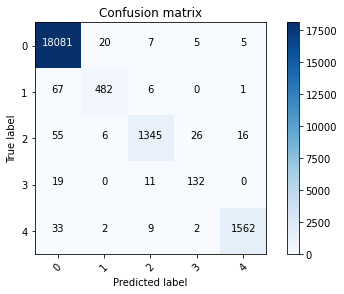

In [ ]:
plot_confusion_matrix(cm , classes = [0 , 1 , 2 , 3 , 4])

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report
print(classification_report(y_true=actual ,y_pred=output ,labels=[0,1,2,3,4] ,target_names =['N','S','V','F','Q']))

              precision    recall  f1-score   support

           N       0.99      1.00      0.99     18118
           S       0.95      0.87      0.90       556
           V       0.98      0.93      0.95      1448
           F       0.80      0.81      0.81       162
           Q       0.99      0.97      0.98      1608

    accuracy                           0.99     21892
   macro avg       0.94      0.92      0.93     21892
weighted avg       0.99      0.99      0.99     21892

